In [1]:
import torch

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

import datamanip.plots
import importlib
from datamanip.datasetmanip.three_five_dataset import ThreeFiveDataset

importlib.reload(datamanip.plots)
importlib.reload(datamanip.datasetmanip.three_five_dataset)



<module 'datamanip.datasetmanip.three_five_dataset' from 'C:\\Users\\pavel\\PycharmProjects\\ADES-reliability\\src\\datamanip\\datasetmanip\\three_five_dataset.py'>

In [2]:

from filepath import *
from datamanip.plots import generate_matrix, visualize_samples_outside_of_radii
from models.GAT import GAT#, GCN, SimpleMPNN
from train_eval.train import train
from train_eval.evaluate import evaluate_multiclass



In [3]:
# Number of epochs to train the model
NUM_EPOCHS = 100

# Dropout rate for the model to prevent overfitting
DROPOUT_RATE = 0.3

# Learning rate for the optimizer
LEARNING_RATE = 0.0005

# Threshold for classifying reliability
THRESHOLD = 0.97

# Number of features for each node in the graph
NODE_FEATURES = 12

# Number of epochs to wait for improvement before early stopping
PATIENCE = 20

# Flag to indicate whether to use only one timestamp
ONE_TIMESTAMP = False

NUM_BINS = 8

In [4]:
train_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="train")
test_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="test")
val_set = ThreeFiveDataset(root=dataset_path, match='ensemble', test_train_val="val")
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(input_dim=NODE_FEATURES, hidden_dim=64, output_dim=NUM_BINS, dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
train_config = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "device": device,
    "criterion": criterion,
    "optimizer": optimizer,
}

In [7]:
train(model, train_loader, val_loader, train_config, model_checkpoints_path + "best_model_GAT_MCC.pth")

Epoch 1/100, Train Loss: 1.2662
Epoch 1/100, Validation Loss: 1.2257
Best model updated based on validation loss.
Epoch 2/100, Train Loss: 1.0213
Epoch 2/100, Validation Loss: 0.9699
Best model updated based on validation loss.
Epoch 3/100, Train Loss: 0.9505
Epoch 3/100, Validation Loss: 0.9412
Best model updated based on validation loss.
Epoch 4/100, Train Loss: 0.9265
Epoch 4/100, Validation Loss: 0.8571
Best model updated based on validation loss.
Epoch 5/100, Train Loss: 0.8985
Epoch 5/100, Validation Loss: 0.9569
No improvement in validation loss for 1 epoch(s).
Epoch 6/100, Train Loss: 0.8762
Epoch 6/100, Validation Loss: 0.8104
Best model updated based on validation loss.
Epoch 7/100, Train Loss: 0.8487
Epoch 7/100, Validation Loss: 0.9484
No improvement in validation loss for 1 epoch(s).
Epoch 8/100, Train Loss: 0.8377
Epoch 8/100, Validation Loss: 0.7217
Best model updated based on validation loss.
Epoch 9/100, Train Loss: 0.8315
Epoch 9/100, Validation Loss: 1.1436
No improv

([1.2662372547714125,
  1.021321220638273,
  0.9505331792125103,
  0.9264631420099156,
  0.8984600615853097,
  0.8761683260471307,
  0.8487401907438139,
  0.837710335420258,
  0.8315468133045401,
  0.836227361637167,
  0.8075179055232392,
  0.7959679941238621,
  0.7948921060151826,
  0.7841078689219986,
  0.779602305593854,
  0.7652229474744111,
  0.768379342229951,
  0.7592249607739452,
  0.7700281384794274,
  0.7600297196811155,
  0.7520220137367823,
  0.7391518044852742,
  0.7420132797996765,
  0.7476409602069972,
  0.7328612856617278,
  0.7314330882907427,
  0.728641962045237,
  0.7240026654021903,
  0.7207286858309538,
  0.7141195240200995,
  0.7172398753670292,
  0.7020534798273955,
  0.6908530706852289,
  0.7053321661323437,
  0.6917215202876081,
  0.695063786834167,
  0.6859567072872157,
  0.6903351949048174,
  0.6875783392785147,
  0.6829507443241056,
  0.6805884412775468,
  0.6749721164526057,
  0.6770085299681796,
  0.6715613925427693,
  0.6679976056636149,
  0.6676776020271

In [8]:
# Load the best model after training
model.load_state_dict(torch.load(model_checkpoints_path + "best_model_GAT_MCC.pth", weights_only=True))

<All keys matched successfully>

In [9]:
true_values, predicted_values, distance, accuracy, rmse, outside_1, outside_2 = evaluate_multiclass(device, model, test_loader, model_checkpoints_path + "best_model_GAT_MCC.pth")
print(f"Cumulative distance is {distance}")
print(f"RMSE is {rmse}")
print(f"Accuracy is {accuracy}")
#print(f"F1 score is {f1}")
print(f"Percentage of samples with distance more than 1 is {outside_1}")
print(f"Percentage of samples with distance more than 2 is {outside_2}")

GAT(
  (conv1): GATConv(12, 64, heads=1)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(64, 32, heads=1)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=8, bias=True)
)
[np.int64(1), np.int64(6), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(6), np.int64(6), np.int64(6), np.int64(2)]
[np.int64(1), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(6), np.int64(4), np.int64(6), np.int64(2)]
Accuracy: 0.7535
Cumulative distance is 5425
RMSE is 0.5589365081612447
Accuracy is 0.7534696228044918
Percentage of samples with distance more than 1 is 0.020328246472790096
Percentage of samples with distance more than 2 is 0.000978980708321336


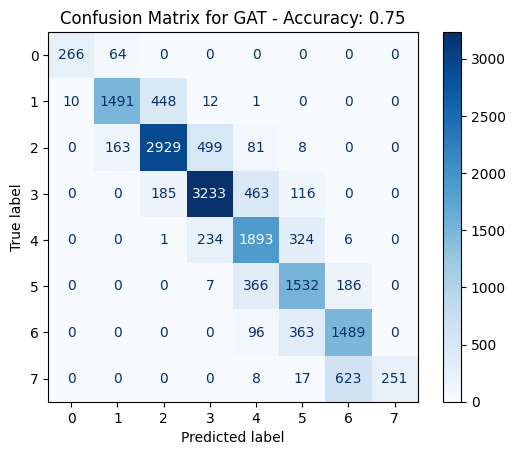

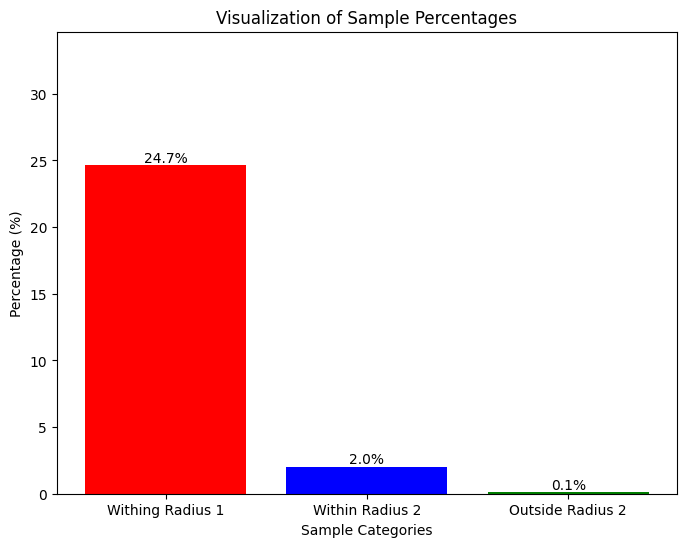

In [11]:
generate_matrix(true_values, predicted_values, accuracy, "GAT")
visualize_samples_outside_of_radii(accuracy, outside_1, outside_2)